In [1]:
import pandas as pd
import numpy as np
import datetime
import requests
from requests.auth import HTTPBasicAuth
import tarfile
import os
import shutil
import warnings
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import math

#keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout,Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.models import Model,Sequential 
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def get_organize_files(): 
    #download files with images
    #https://talhassner.github.io/home/projects/Adience/Adience-data.html
    print('starting download')
    BASE_URL = "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification"
    DOWNLOAD_FILES = {
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/aligned.tar.gz": "aligned.tar.gz",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_0_data.txt": "fold_0_data.txt",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_1_data.txt": "fold_1_data.txt",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_2_data.txt": "fold_2_data.txt",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_3_data.txt": "fold_3_data.txt",
              "http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_4_data.txt": "fold_4_data.txt"
                    }

    for DOWNLOAD_FILE, FILE_NAME in DOWNLOAD_FILES.items():
        if not os.path.exists(FILE_NAME):
            with open(FILE_NAME, 'wb') as file:
                r = requests.get(DOWNLOAD_FILE, auth = HTTPBasicAuth('adiencedb', 'adience'))
                file.write(r.content)
                print('downloaded {}'.format(FILE_NAME))
    
    
    
    if not os.path.exists('aligned'):
        with tarfile.open('aligned.tar.gz') as file:
            print('unziping images...')
            file.extractall()
            print('images unziped')
        
   
    
    #compile all files catalog
    fold = pd.read_csv('fold_0_data.txt',sep='\t')
    fold.rename(columns={' user_id':'user_id'},inplace=True)
    fold['fold'] = 0
    for i in range(1,5):
        temp = pd.read_csv('fold_'+str(i)+'_data.txt',sep='\t')
        temp['fold'] = i
        fold = fold.append(temp,ignore_index=True)

    fold.dropna(subset=['gender'],inplace=True)
    fold = fold[['user_id','original_image','face_id','age','gender','fold']]
    
    fold = fold.loc[fold.age !='None']
    fold.age.replace(['35'     ,'13'    ,'22'     ,'34'     ,'45'      ,'(27, 32)','23'      ,'55'      ,'36'     ,'(38, 42)','57'      ,'58'      ,'46'      ,'3'      ,'29'     ,'2'     ,'42'],
                     ['(35,43)','(8,13)','(15,24)','(25,34)','(45,100)','(25,34)' ,'(15,24)','(45,100)','(35,43)','(35,43)' ,'(45,100)','(45,100)','(45,100)','(3, 6)','(25,34)','(0, 2)','(35,43)'],
                     inplace = True)
    fold.age.replace(['(38, 43)','(8, 12)','(15, 20)','(60, 100)','(38, 43)','(48, 53)','(4, 6)','(38, 48)','(25, 32)','(8, 23)'],
                     ['(35,43)' ,'(8,13)' ,'(15,24)' ,'(45,100)' ,'(35,43)' ,'(45,100)','(3, 6)','(45,100)','(25,34)' ,'(8,13)'],
                     inplace=True)
     
    train = fold.groupby('gender',as_index=False,group_keys=False).apply(lambda x: x.sample(frac=.5))
    test = fold.drop(train.index.values)
    
    print('Train and test split done')
    
    #creates directories for training, test and validation files
    cwd = os.getcwd()
    
    train_faces = os.path.join(cwd,'train')
    if not os.path.exists(train_faces):
        os.mkdir(train_faces)

    test_faces = os.path.join(cwd,'test')
    if not os.path.exists(test_faces):
        os.mkdir(test_faces)

    #copy images to each directory
    for index, row in train.iterrows():
        src = os.path.join(cwd,'aligned',row['user_id'],'landmark_aligned_face.'+str(row['face_id'])+'.'+row['original_image'])
        dst = os.path.join(train_faces,row['original_image'])
        shutil.copyfile(src,dst)

    print('train images copied')

    for index, row in test.iterrows():
        src = os.path.join(cwd,'aligned',row['user_id'],'landmark_aligned_face.'+str(row['face_id'])+'.'+row['original_image'])
        dst = os.path.join(test_faces,row['original_image'])
        shutil.copyfile(src,dst)

    print('test images copied')
    
    return cwd,train_faces,test_faces,train,test


In [3]:
cwd,train_faces,test_faces,train_images_ids, test_images_ids = get_organize_files()

starting download
Train and test split done
train images copied
test images copied


In [21]:
def viz_overfit(model,history,num_of_test_samples,batch_size,target_names,epc):
    
    Y_pred = model.predict_generator(test_generator, math.ceil(num_of_test_samples / batch_size))
    
    print(classification_report(test_generator.classes[:Y_pred.shape[0]],
                                list(np.argmax(Y_pred,axis=1)), 
                                target_names=target_names))


    acc_train = history.history['acc']
    acc_val = history.history['val_acc']
    epochs = range(1,epc+1)
    plt.plot(epochs, acc_train, 'g', label='Training accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(1,epc+1)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

In [11]:
def Model_age():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape = (150, 150, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(128, (1, 1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(512, (1, 1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(units = 32, activation = 'relu'))
    
    model.add(Dense(units = 7, activation = 'softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer = optimizers.RMSprop(lr=0.0001), metrics=['acc'])
    
    return model
model_age = Model_age()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 36, 36, 128)       8320      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 256)      

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
                    train_images_ids,
                    x_col='original_image',
                    y_col='age',
                    directory=train_faces,
                    target_size=(150,150),
                    batch_size=100,
                    class_mode='categorical'
                )

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
                    test_images_ids,
                    x_col='original_image',
                    y_col='age',
                    directory=test_faces,
                    target_size=(150,150),
                    batch_size=100,
                    class_mode='categorical'
                )

Found 9276 validated image filenames belonging to 7 classes.
Found 9275 validated image filenames belonging to 7 classes.


In [12]:
history_age = model_age.fit(train_generator,
                              steps_per_epoch=93,
                              epochs=25,
                              validation_data = test_generator,
                              validation_steps=93)
model_age.save('face_age_detection.h5')

2022-04-13 13:35:41.277219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 18 of 93
2022-04-13 13:35:50.792486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 13:36:00.955758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 13:36:10.995676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 68 of 93
2022-04-13 13:36:21.064302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 85 of 93
2022-04-13 13:36:25.673412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


Train for 93 steps, validate for 93 steps
Epoch 1/25


2022-04-13 13:36:38.090878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 13:36:48.078108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 13:36:58.590137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 52 of 93
2022-04-13 13:37:08.042329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 67 of 93
2022-04-13 13:37:18.095602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 84 of 93
2022-04-13 13:37:23.349943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1036s 11s/step - loss: 1.9094 - acc: 0.2351 - val_loss: 1.8737 - val_acc: 0.2759
Epoch 2/25


2022-04-13 13:53:53.310051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 13:54:03.432351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 13:54:13.605903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 13:54:23.265595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 67 of 93
2022-04-13 13:54:33.474664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 84 of 93
2022-04-13 13:54:38.790277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1034s 11s/step - loss: 1.8889 - acc: 0.2676 - val_loss: 1.8679 - val_acc: 0.2759
Epoch 3/25


2022-04-13 14:11:07.360550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 14:11:17.500764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 14:11:27.694166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 14:11:37.312095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 67 of 93
2022-04-13 14:11:47.511756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 84 of 93
2022-04-13 14:11:52.791212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1037s 11s/step - loss: 1.8642 - acc: 0.2806 - val_loss: 1.8274 - val_acc: 0.2801
Epoch 4/25


2022-04-13 14:28:24.090758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 14:28:34.232928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 14:28:44.334518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 14:28:54.474989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 68 of 93
2022-04-13 14:29:04.113886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 84 of 93
2022-04-13 14:29:09.360934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1042s 11s/step - loss: 1.8381 - acc: 0.2900 - val_loss: 1.7966 - val_acc: 0.3154
Epoch 5/25


2022-04-13 14:45:45.946003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 14:45:56.048724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 14:46:06.170938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 14:46:16.286765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 68 of 93
2022-04-13 14:46:26.410515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 85 of 93
2022-04-13 14:46:31.080671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1041s 11s/step - loss: 1.8101 - acc: 0.3038 - val_loss: 1.7718 - val_acc: 0.3376
Epoch 6/25


2022-04-13 15:03:07.409078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 15:03:17.542711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 15:03:27.650034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 15:03:37.745598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 68 of 93
2022-04-13 15:03:47.290678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 84 of 93
2022-04-13 15:03:52.564239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1046s 11s/step - loss: 1.7780 - acc: 0.3232 - val_loss: 1.7258 - val_acc: 0.3399
Epoch 7/25


2022-04-13 15:20:32.950854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 15:20:42.947475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 15:20:52.928209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 15:21:02.967705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 68 of 93
2022-04-13 15:21:13.060948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 85 of 93
2022-04-13 15:21:17.659288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1043s 11s/step - loss: 1.7500 - acc: 0.3369 - val_loss: 1.6965 - val_acc: 0.3435
Epoch 8/25


2022-04-13 15:37:56.452037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 15:38:06.562379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 15:38:16.636975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 15:38:26.764530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 68 of 93
2022-04-13 15:38:36.340072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 84 of 93
2022-04-13 15:38:41.598562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1045s 11s/step - loss: 1.7199 - acc: 0.3430 - val_loss: 1.6590 - val_acc: 0.3623
Epoch 9/25


2022-04-13 15:55:21.648743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 15:55:31.750402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 15:55:41.818040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 15:55:51.875948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 68 of 93
2022-04-13 15:56:02.009043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 85 of 93
2022-04-13 15:56:06.662044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1049s 11s/step - loss: 1.6889 - acc: 0.3591 - val_loss: 1.6451 - val_acc: 0.3611
Epoch 10/25


2022-04-13 16:12:50.457300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 16:13:00.542439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 16:13:10.650674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 16:13:20.759131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 68 of 93
2022-04-13 16:13:30.848386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 85 of 93
2022-04-13 16:13:35.529852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1051s 11s/step - loss: 1.6470 - acc: 0.3716 - val_loss: 1.5998 - val_acc: 0.3725
Epoch 11/25


2022-04-13 16:30:21.324230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 16:30:31.455037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 16:30:41.556792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 16:30:51.681497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 68 of 93
2022-04-13 16:31:01.248336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 84 of 93
2022-04-13 16:31:06.540971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1052s 11s/step - loss: 1.6166 - acc: 0.3779 - val_loss: 1.5658 - val_acc: 0.3816
Epoch 12/25


2022-04-13 16:47:53.416334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 16:48:03.532139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 16:48:13.638593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 16:48:23.771684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 68 of 93
2022-04-13 16:48:33.333655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 84 of 93
2022-04-13 16:48:38.606283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1051s 11s/step - loss: 1.5917 - acc: 0.3855 - val_loss: 1.5468 - val_acc: 0.3976
Epoch 13/25


2022-04-13 17:05:24.105597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 17:05:34.318152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 17:05:43.986621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 50 of 93
2022-04-13 17:05:54.338893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 67 of 93
2022-04-13 17:06:03.993476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 83 of 93
2022-04-13 17:06:09.960628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1038s 11s/step - loss: 1.5621 - acc: 0.3938 - val_loss: 1.5128 - val_acc: 0.4014
Epoch 14/25


2022-04-13 17:22:41.756519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 17:22:51.891287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 17:23:02.043506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 17:23:11.659907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 67 of 93
2022-04-13 17:23:21.987514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 84 of 93
2022-04-13 17:23:27.302918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1055s 11s/step - loss: 1.5332 - acc: 0.4035 - val_loss: 1.5021 - val_acc: 0.4146
Epoch 15/25


2022-04-13 17:40:17.013172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 17:40:27.161556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 17:40:37.305583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 17:40:46.866355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 67 of 93
2022-04-13 17:40:57.073868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 84 of 93
2022-04-13 17:41:02.393253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1048s 11s/step - loss: 1.5186 - acc: 0.4113 - val_loss: 1.5023 - val_acc: 0.4111
Epoch 16/25


2022-04-13 17:57:44.489679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 17:57:54.635047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 17:58:04.780592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 17:58:14.382547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 67 of 93
2022-04-13 17:58:24.683934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 84 of 93
2022-04-13 17:58:29.967722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1048s 11s/step - loss: 1.4960 - acc: 0.4212 - val_loss: 1.4695 - val_acc: 0.4237
Epoch 17/25


2022-04-13 18:15:12.121907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 18:15:22.282883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 18:15:32.426856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 18:15:41.993303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 67 of 93
2022-04-13 18:15:52.231575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 84 of 93
2022-04-13 18:15:57.559437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1049s 11s/step - loss: 1.4724 - acc: 0.4298 - val_loss: 1.4515 - val_acc: 0.4380
Epoch 18/25


2022-04-13 18:32:40.619176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 18:32:50.750531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 18:33:00.864619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 18:33:11.034049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 68 of 93
2022-04-13 18:33:20.650668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 84 of 93
2022-04-13 18:33:25.914497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1057s 11s/step - loss: 1.4590 - acc: 0.4293 - val_loss: 1.4391 - val_acc: 0.4396
Epoch 19/25


2022-04-13 18:50:17.495347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 18:50:27.652237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 18:50:37.779788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 18:50:47.350176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 67 of 93
2022-04-13 18:50:57.600396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 84 of 93
2022-04-13 18:51:02.869106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1051s 11s/step - loss: 1.4478 - acc: 0.4346 - val_loss: 1.4625 - val_acc: 0.4429
Epoch 20/25


2022-04-13 19:07:48.895081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 19:07:59.097134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 19:08:08.702287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 50 of 93
2022-04-13 19:08:18.978626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 67 of 93
2022-04-13 19:08:28.682819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 83 of 93
2022-04-13 19:08:34.612387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1041s 11s/step - loss: 1.4301 - acc: 0.4398 - val_loss: 1.4313 - val_acc: 0.4484
Epoch 21/25


2022-04-13 19:25:09.729885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 19:25:19.931195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 19:25:29.500456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 50 of 93
2022-04-13 19:25:39.683928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 67 of 93
2022-04-13 19:25:49.853572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 84 of 93
2022-04-13 19:25:55.177941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1043s 11s/step - loss: 1.3952 - acc: 0.4531 - val_loss: 1.4334 - val_acc: 0.4514
Epoch 22/25


2022-04-13 19:42:32.432254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 19:42:42.321950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 33 of 93
2022-04-13 19:42:52.231927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 49 of 93
2022-04-13 19:43:02.244086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 65 of 93
2022-04-13 19:43:12.252931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 81 of 93
2022-04-13 19:43:19.623620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1039s 11s/step - loss: 1.3729 - acc: 0.4645 - val_loss: 1.4487 - val_acc: 0.4594
Epoch 23/25


2022-04-13 19:59:51.699109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 20:00:01.853281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 20:00:12.018761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 20:00:21.592636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 67 of 93
2022-04-13 20:00:31.747032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 84 of 93
2022-04-13 20:00:36.999387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1057s 11s/step - loss: 1.4429 - acc: 0.4532 - val_loss: 1.4317 - val_acc: 0.4461
Epoch 24/25


2022-04-13 20:17:28.441474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 20:17:38.622797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 20:17:48.816171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 51 of 93
2022-04-13 20:17:58.447696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 67 of 93
2022-04-13 20:18:08.760831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 84 of 93
2022-04-13 20:18:14.042692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 1040s 11s/step - loss: 1.4334 - acc: 0.4543 - val_loss: 1.4159 - val_acc: 0.4675
Epoch 25/25


2022-04-13 20:34:48.146289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 17 of 93
2022-04-13 20:34:58.338228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 34 of 93
2022-04-13 20:35:07.917803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 50 of 93
2022-04-13 20:35:18.096033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 67 of 93
2022-04-13 20:35:28.363959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 84 of 93
2022-04-13 20:35:33.694095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


93/93 [==============================] - 2258s 24s/step - loss: 1.4030 - acc: 0.4615 - val_loss: 1.4172 - val_acc: 0.4664


              precision    recall  f1-score   support

      (0, 2)       0.12      0.14      0.13      1243
     (15,24)       0.10      0.06      0.07       946
     (25,34)       0.27      0.45      0.34      2559
      (3, 6)       0.13      0.15      0.14      1081
     (35,43)       0.10      0.02      0.03      1298
    (45,100)       0.10      0.05      0.07       975
      (8,13)       0.13      0.12      0.13      1173

    accuracy                           0.19      9275
   macro avg       0.13      0.14      0.13      9275
weighted avg       0.16      0.19      0.16      9275



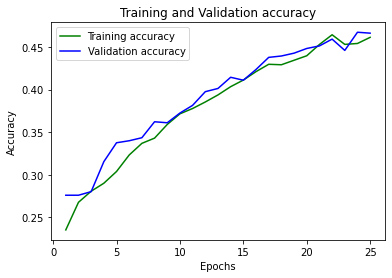

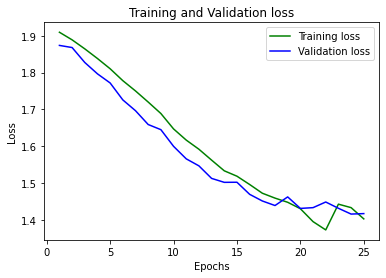

In [22]:
viz_overfit(model_age,history_age, 9276,100,list(train_generator.class_indices.keys()),50)